In [1]:
import matplotlib_inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.rcParams['font.family'] = 'PingFang HK'

## 讀取資料

In [2]:
df = pd.read_excel("../Online_Retail001.xlsx")
df.shape

(10000, 8)

df.head()

In [3]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10000.000000,10000,10000.000000,7526.000000
mean,10.158300,2011-07-02 06:06:49.842000128,3.881760,15266.947250
min,-600.000000,2010-12-01 08:45:00,0.000000,12347.000000
25%,1.000000,2011-03-24 13:10:00,1.250000,13908.000000
50%,3.000000,2011-07-15 14:05:00,2.080000,15128.000000
75%,12.000000,2011-10-17 15:06:15,4.130000,16759.000000
max,4000.000000,2011-12-09 12:50:00,736.380000,18283.000000
std,57.905129,NaN,14.863321,1704.574949


發現 `Quantity` 有負值，`CustomerID` 有空值

## 資料清理

### 處理 `Quantity` 負值

In [4]:
df = df[df["Quantity"] > 0]

### 處理 `CustomerID` 空值問題

計算空值個數。

In [5]:
df["CustomerID"].isnull().sum()

np.int64(2442)

刪除 customerid 中的空值。

In [6]:
df.dropna(subset=["CustomerID"], inplace=True)

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom


### 計算 Sales

In [8]:
df["Sales"] = df["Quantity"] * df["UnitPrice"]

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.00
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom,20.34
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom,16.50
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom,5.10
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom,87.60


## 資料分析

## 計算每個顧客的 RFM 資料

抓出 InvoiceDate 的最大值。

In [10]:
maximum = df["InvoiceDate"].max()

maximum

Timestamp('2011-12-09 12:50:00')

為了簡化接下來的操作，假設今天是 2011-12-31。

In [11]:
from datetime import datetime


today = datetime(2011, 12, 31)

計算每個客戶的 RFM。

In [12]:
summary_df = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (today - x.max())),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Sales", "sum"),
)

summary_df

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,23 days 08:08:00,2,28.20
12348.0,96 days 10:47:00,1,40.00
12349.0,39 days 14:09:00,1,339.00
12352.0,93 days 09:02:00,2,36.60
12354.0,253 days 10:49:00,1,23.40
...,...,...,...
18261.0,116 days 14:26:00,1,17.00
18263.0,46 days 15:00:00,2,40.32
18265.0,93 days 09:50:00,1,15.90


In [13]:
summary_df["Recency"].dtype

dtype('<m8[ns]')

把 Recency 轉成天數。

In [14]:
summary_df["RecencyDays"] = summary_df["Recency"].dt.days

summary_df

,Recency,Frequency,Monetary,RecencyDays
CustomerID,,,,
12347.0,23 days 08:08:00,2,28.20,23
12348.0,96 days 10:47:00,1,40.00,96
12349.0,39 days 14:09:00,1,339.00,39
12352.0,93 days 09:02:00,2,36.60,93
12354.0,253 days 10:49:00,1,23.40,253
...,...,...,...,...
18261.0,116 days 14:26:00,1,17.00,116
18263.0,46 days 15:00:00,2,40.32,46
18265.0,93 days 09:50:00,1,15.90,93


## RFM 分佈圖

### 直方圖

顧客購買次數 (F) 分佈圖。

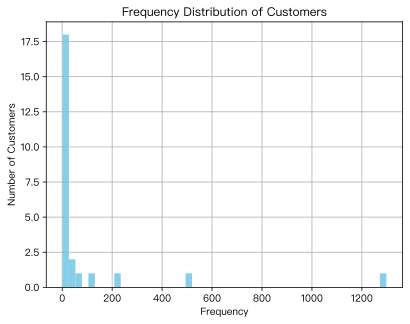

In [15]:
ax = summary_df.groupby("Frequency")["Monetary"].count().sort_values(ascending=False).plot(
    kind="hist",
    color="skyblue",
    grid=True,
    bins=50,
)

ax.set_xlabel("Frequency")
ax.set_ylabel("Number of Customers")
ax.set_title("Frequency Distribution of Customers")

plt.show()

顧客購買天數 (R) 分佈圖——不適合長條圖（連續數值多），使用直方圖。

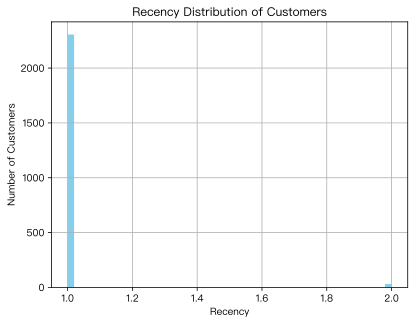

In [16]:
ax = summary_df.groupby("Recency")["Monetary"].count().sort_values(ascending=False).plot(
    kind="hist",
    color="skyblue",
    grid=True,
    bins=50,
)

ax.set_xlabel("Recency")
ax.set_ylabel("Number of Customers")
ax.set_title("Recency Distribution of Customers")

plt.show()

顧客購買金額 (M) 分布圖。

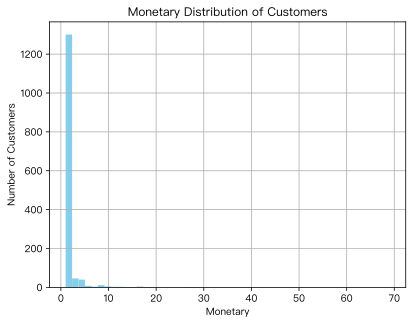

In [17]:
ax = summary_df.groupby("Monetary")["Monetary"].count().sort_values(ascending=False).plot(
    kind="hist",
    color="skyblue",
    grid=True,
    bins=50,
)

ax.set_xlabel("Monetary")
ax.set_ylabel("Number of Customers")
ax.set_title("Monetary Distribution of Customers")

plt.show()

### 盒鬚圖

顧客購買次數 (F) 盒鬚圖，發現 outliers 很多。

Text(0.5, 1.0, 'Frequency Distribution of Customers')

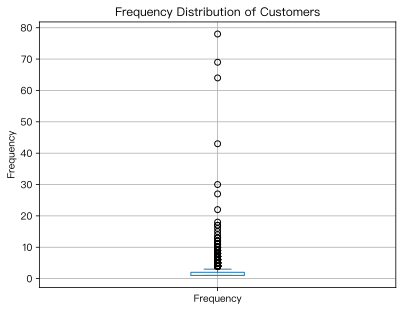

In [18]:
ax = summary_df["Frequency"].plot(
    kind="box",
    showfliers=True,
    grid=True,
)

ax.set_ylabel("Frequency")
ax.set_title("Frequency Distribution of Customers")


顧客購買天數 (R) 盒鬚圖，發現 outlier 不多。

Text(0.5, 1.0, 'Recency Distribution of Customers')

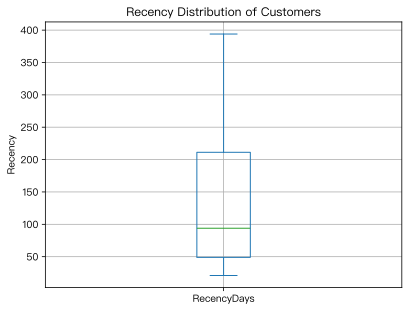

In [19]:
ax = summary_df["RecencyDays"].plot(
    kind="box",
    showfliers=True,
    grid=True,
)

ax.set_ylabel("Recency")
ax.set_title("Recency Distribution of Customers")

顧客購買金額 (M) 盒鬚圖，發現 Outlier 很多。

Text(0.5, 1.0, 'Monetary Distribution of Customers')

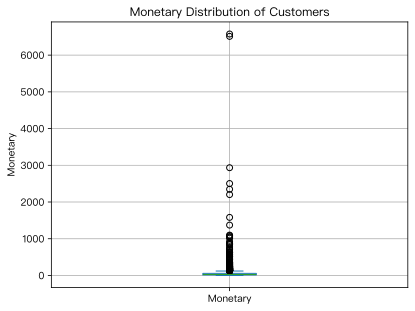

In [20]:
ax = summary_df["Monetary"].plot(
    kind="box",
    showfliers=True,
    grid=True,
)

ax.set_ylabel("Monetary")
ax.set_title("Monetary Distribution of Customers")

## 自訂 RF

將 RF 自訂分成高低，然後畫圖，依中位數或平均數切 frequency 高低。

In [21]:
summary_df['Frequency'].apply(
    lambda x: 'High' if x > summary_df['Frequency'].mean() else 'Low'
).to_frame()


,Frequency
CustomerID,
12347.0,Low
12348.0,Low
12349.0,Low
12352.0,Low
12354.0,Low
...,...
18261.0,Low
18263.0,Low
18265.0,Low


In [22]:
summary_df['FrequencyLabel'] = summary_df['Frequency'].apply(
    lambda x: 'High' if x > summary_df['Frequency'].median() else 'Low'
)

summary_df["FrequencyLabel"].to_frame()


,FrequencyLabel
CustomerID,
12347.0,High
12348.0,Low
12349.0,Low
12352.0,High
12354.0,Low
...,...
18261.0,Low
18263.0,High
18265.0,Low


依中位數或平均數切 recency 高低。

In [23]:
summary_df['RecencyDays'].apply(
    lambda x: 'High' if x > summary_df['RecencyDays'].median() else 'Low'
).to_frame()


,RecencyDays
CustomerID,
12347.0,Low
12348.0,High
12349.0,Low
12352.0,Low
12354.0,High
...,...
18261.0,High
18263.0,Low
18265.0,Low


In [24]:
summary_df['RecencyLabel'] = summary_df['RecencyDays'].apply(
    lambda x: 'High' if x > summary_df['RecencyDays'].median() else 'Low'
)

summary_df['RecencyLabel'].to_frame()


,RecencyLabel
CustomerID,
12347.0,Low
12348.0,High
12349.0,Low
12352.0,Low
12354.0,High
...,...
18261.0,High
18263.0,Low
18265.0,Low


## 依 FM 高低值將顧客分群命名

In [25]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2368 entries, 12347.0 to 18283.0
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   Recency         2368 non-null   timedelta64[ns]
 1   Frequency       2368 non-null   int64          
 2   Monetary        2368 non-null   float64        
 3   RecencyDays     2368 non-null   int64          
 4   FrequencyLabel  2368 non-null   object         
 5   RecencyLabel    2368 non-null   object         
dtypes: float64(1), int64(2), object(2), timedelta64[ns](1)
memory usage: 129.5+ KB


In [26]:
# Define a mapping for the labels
label_mapping = {
    ('High', 'Low'): '常貴客',
    ('High', 'High'): '先前客',
    ('Low', 'Low'): '新顧客',
}

# Create a new column with default value '流失客'
summary_df['CustomerLabel'] = '流失客'

# Use .apply() with a lambda function to assign the correct labels based on the mapping
summary_df['CustomerLabel'] = summary_df.apply(
    lambda row: label_mapping.get((row['FrequencyLabel'], row['RecencyLabel']), '流失客'),
    axis=1
)

summary_df

,Recency,Frequency,Monetary,RecencyDays,FrequencyLabel,RecencyLabel,CustomerLabel
CustomerID,,,,,,,
12347.0,23 days 08:08:00,2,28.20,23,High,Low,常貴客
12348.0,96 days 10:47:00,1,40.00,96,Low,High,流失客
12349.0,39 days 14:09:00,1,339.00,39,Low,Low,新顧客
12352.0,93 days 09:02:00,2,36.60,93,High,Low,常貴客
12354.0,253 days 10:49:00,1,23.40,253,Low,High,流失客
...,...,...,...,...,...,...,...
18261.0,116 days 14:26:00,1,17.00,116,Low,High,流失客
18263.0,46 days 15:00:00,2,40.32,46,High,Low,常貴客
18265.0,93 days 09:50:00,1,15.90,93,Low,Low,新顧客


### 顧客分群繪圖

X 軸為 Frequency， Y 軸為 Recency

#### 散佈圖

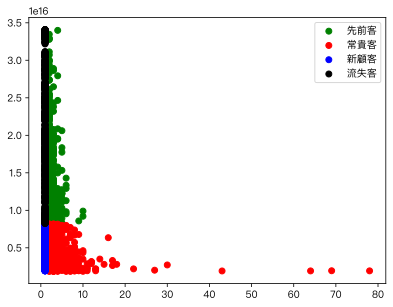

In [27]:
ax = plt.subplot()
color = {
    "常貴客": "red",
    "先前客": "green",
    "新顧客": "blue",
    "流失客": "black",
}

for label, customer_label in summary_df.groupby("CustomerLabel"):
    label_str = str(label)
    ax.scatter(x=customer_label["Frequency"], y=customer_label["Recency"], label=label_str, color=color[label_str])

ax.legend()

plt.show()

#### 泡泡圖

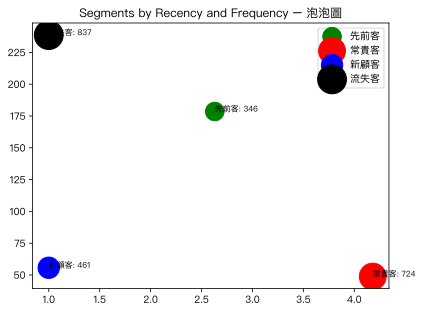

In [ ]:
ax = plt.subplot()
color = {
    "常貴客": "red",
    "先前客": "green",
    "新顧客": "blue",
    "流失客": "black",
}

summary_df_agg = summary_df.groupby("CustomerLabel").agg(
    RecencyDays=("RecencyDays", "mean"),
    Frequency=("Frequency", "mean"),
    Monetary=("Monetary", "count"),
    CustomerLabel=("CustomerLabel", "max"),
)

for i in range(len(summary_df_agg)):
    row = summary_df_agg.iloc[i]
    ax.scatter(x=row["Frequency"], y=row["RecencyDays"], s=row["Monetary"], label=row["CustomerLabel"], color=color[row["CustomerLabel"]])

    ax.annotate(f"{row["CustomerLabel"]}: {row["Monetary"]}", (row["Frequency"], row["RecencyDays"]), fontsize=8)
    # plt.text(row['Frequency'], row['RecencyDays'], f"{row['CustomerLabel']}: {row['Monetary']}", fontsize=8, ha='right', va='bottom')

ax.set_title("Segments by Recency and Frequency – 泡泡圖")

ax.legend()

plt.show()

## 探索性分析

In [29]:
# Filter the DataFrame for high-value customers
high_value_cluster = summary_df.loc[summary_df['CustomerLabel'] == "常貴客"]

# Display the first few rows of the high-value cluster
high_value_cluster.head()

# Calculate the mean sales for the high-value customers
high_value_cluster_salesmean = high_value_cluster["Monetary"].mean()

In [30]:
# Print the average sales amount for high-value customers
print(f'常貴客平均銷售額: {high_value_cluster_salesmean}')

常貴客平均銷售額: 126.50118784530387


### 請問常貴客 RFM 的平均數值? 

In [31]:
high_value_cluster = summary_df.loc[summary_df['CustomerLabel'] == "常貴客"]
high_value_cluster[["Recency", "Frequency", "Monetary"]].mean().to_frame()

,0
Recency,49 days 06:34:37.541436464
Frequency,4.180939
Monetary,126.501188
